In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [4]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [5]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [6]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_class']  # this column contains the labels

In [7]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [8]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [9]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [10]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [11]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

In [12]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [13]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [14]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 0, 1, 0, 1])

In [15]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [16]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [17]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [18]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[ 0.3769, -1.5554,  0.7419, -2.0522,  1.1256,  1.3298, -2.8264, -0.3311,
           1.1766,  2.9050,  0.3846,  0.8003],
         [-0.9786,  0.2039,  0.9849, -0.3154,  1.7938,  1.1731,  1.0925,  0.7311,
           1.4540, -1.1304,  0.2480,  0.6821],
         [-0.2718, -0.9512, -0.3173,  0.8704, -1.2670, -0.9128,  0.2215, -1.0912,
          -1.3004, -0.4506, -0.9580,  0.3774],
         [ 0.0297,  1.6190, -0.9036,  2.8598, -0.7421,  0.9372, -1.5792, -1.1644,
           1.3257, -0.0956, -1.0504,  0.7205]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.9476],
         [-1.9476],
         [-1.9476],
         [ 0.4037]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.7056, -0.5498,  0.2783, -0.5731],
         [-0.2235, -1.0335,  3.3049, -1.2834],
         [-0.2235, -1.0335,  3.3049, -1.2834],
         [-1.0943,  2.9820, -0.6270,  2.1175]], grad_fn=<EmbeddingBackward>)]

In [19]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[ 0.3769, -1.5554,  0.7419, -2.0522,  1.1256,  1.3298, -2.8264, -0.3311,
          1.1766,  2.9050,  0.3846,  0.8003, -1.9476, -1.7056, -0.5498,  0.2783,
         -0.5731],
        [-0.9786,  0.2039,  0.9849, -0.3154,  1.7938,  1.1731,  1.0925,  0.7311,
          1.4540, -1.1304,  0.2480,  0.6821, -1.9476, -0.2235, -1.0335,  3.3049,
         -1.2834],
        [-0.2718, -0.9512, -0.3173,  0.8704, -1.2670, -0.9128,  0.2215, -1.0912,
         -1.3004, -0.4506, -0.9580,  0.3774, -1.9476, -0.2235, -1.0335,  3.3049,
         -1.2834],
        [ 0.0297,  1.6190, -0.9036,  2.8598, -0.7421,  0.9372, -1.5792, -1.1644,
          1.3257, -0.0956, -1.0504,  0.7205,  0.4037, -1.0943,  2.9820, -0.6270,
          2.1175]], grad_fn=<CatBackward>)

In [20]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [21]:
z = selfembdrop(z)
z

tensor([[ 0.0000, -2.5923,  1.2365, -3.4203,  1.8759,  0.0000, -4.7107, -0.0000,
          1.9610,  0.0000,  0.0000,  1.3338, -3.2461, -2.8427, -0.0000,  0.0000,
         -0.9552],
        [-0.0000,  0.3399,  1.6416, -0.5257,  2.9896,  0.0000,  0.0000,  0.0000,
          2.4234, -1.8840,  0.4134,  0.0000, -0.0000, -0.3725, -0.0000,  0.0000,
         -0.0000],
        [-0.4531, -1.5854, -0.5288,  0.0000, -0.0000, -1.5213,  0.3691, -1.8186,
         -0.0000, -0.7510, -1.5966,  0.6290, -0.0000, -0.3725, -0.0000,  0.0000,
         -0.0000],
        [ 0.0000,  0.0000, -0.0000,  4.7663, -1.2368,  0.0000, -2.6320, -0.0000,
          0.0000, -0.0000, -1.7506,  1.2009,  0.0000, -1.8238,  4.9701, -1.0451,
          3.5292]], grad_fn=<MulBackward0>)

In [22]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [23]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [26]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.73441470
epoch:  26  loss: 0.45091003
epoch:  51  loss: 0.35915548
epoch:  76  loss: 0.31940645
epoch: 101  loss: 0.29913464
epoch: 126  loss: 0.28824872
epoch: 151  loss: 0.28090888
epoch: 176  loss: 0.27713519
epoch: 201  loss: 0.27234775
epoch: 226  loss: 0.27173719
epoch: 251  loss: 0.26835656
epoch: 276  loss: 0.26369372
epoch: 300  loss: 0.25955883

Duration: 150 seconds


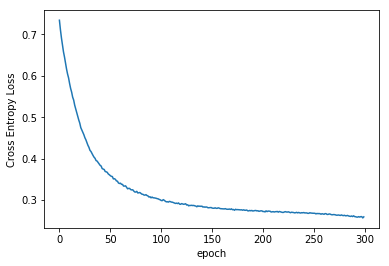

In [27]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [28]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.25458759


In [29]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 1.8184, -1.6424])    0      0   
tensor([-1.8321,  2.6454])    1      0   
tensor([ 1.4068, -1.9226])    0      0   
tensor([-1.9097,  1.4965])    1      1   
tensor([ 1.1796, -2.5029])    0      0   
tensor([ 2.1040, -2.3015])    0      0   
tensor([ 1.3281, -1.8246])    0      0   
tensor([-1.6248,  2.3954])    1      1   
tensor([ 2.2527, -2.4193])    0      0   
tensor([-0.4510,  1.1387])    1      1   
tensor([ 1.5167, -2.1575])    0      0   
tensor([ 0.7709, -1.9469])    0      0   
tensor([ 0.9700, -1.3822])    0      0   
tensor([-1.3734,  1.7388])    1      1   
tensor([ 1.4193, -2.4464])    0      0   
tensor([-1.4300,  2.5989])    1      1   
tensor([ 2.2789, -2.5754])    0      1   
tensor([ 1.4559, -2.7905])    0      0   
tensor([ 0.3220, -0.8879])    0      0   
tensor([ 2.0419, -1.9473])    0      0   
tensor([-1.3550,  2.1961])    1      1   
tensor([-0.4771,  0.3081])    1      1   
tensor([-2.0522,  2.2857])    1   

In [30]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareClssModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

In [31]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

In [32]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 2, [200,100], p=0.4)

In [33]:
model2.load_state_dict(torch.load('TaxiFareClssModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [34]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts).argmax().item()
    print(f'\nThe predicted fare class is {z}')

In [ ]:
test_data(model2)